In [131]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

<h2> Data Prep </h2


In [132]:
def get_data_for_coin(crypto):
    endpoint = 'https://min-api.cryptocompare.com/data/histoday'
    res = requests.get(endpoint + f'?fsym={crypto}&tsym=GBP&limit=2000')
    coin_frame = pd.DataFrame(json.loads(res.content)['Data'])
    coin_frame = coin_frame.set_index('time')
    coin_frame.index = pd.to_datetime(coin_frame.index, unit='s')
    coin_frame['daily_delta'] = (coin_frame['close'] - coin_frame['open'])/coin_frame['close']
    del coin_frame['conversionType']
    del coin_frame['conversionSymbol']
    return coin_frame

data = get_data_for_coin("BTC").join(get_data_for_coin("LTC"), lsuffix="_BTC", rsuffix="_LTC").sort_index()
data.head()

,high_BTC,low_BTC,open_BTC,volumefrom_BTC,volumeto_BTC,close_BTC,daily_delta_BTC,high_LTC,low_LTC,open_LTC,volumefrom_LTC,volumeto_LTC,close_LTC,daily_delta_LTC
time,,,,,,,,,,,,,,
2015-10-26,187.71,185.00,187.66,921.14,173704.68,187.09,-0.003047,2.073,1.998,2.006,72742.35,148342.09,2.039,0.016184
2015-10-27,193.68,187.04,187.09,1137.69,217615.80,193.56,0.033426,2.114,2.005,2.039,90458.93,183846.92,2.032,-0.003445
2015-10-28,198.05,192.04,193.56,935.64,186256.68,197.14,0.018160,2.080,1.975,2.032,144606.50,290208.64,2.007,-0.012456
2015-10-29,207.42,192.19,197.14,944.78,194238.40,206.05,0.043242,2.598,1.983,2.007,720906.20,1840444.33,2.553,0.213866
2015-10-30,217.44,205.42,206.05,826.82,177552.74,210.49,0.021094,2.669,2.395,2.553,500891.86,1283116.30,2.562,0.003513


<h2>Plot eth vs btc</h2>


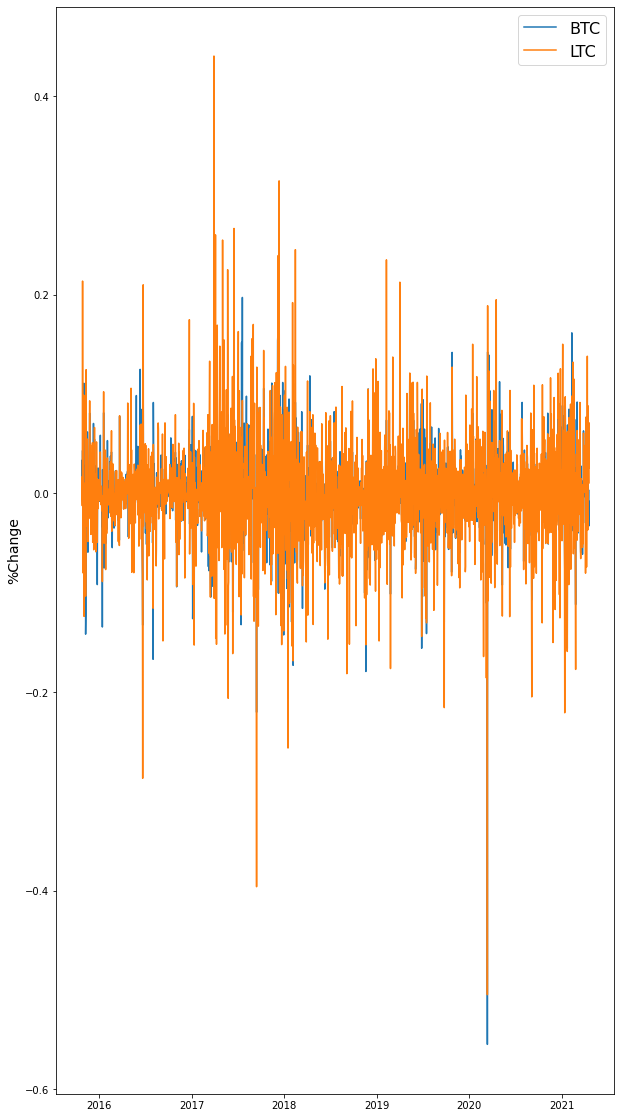

In [133]:
fig, ax = plt.subplots(1, figsize=(10, 20))
ax.set_ylabel('%Change', fontsize=14)
ax.plot(data['daily_delta_BTC'], label="BTC")
ax.plot(data['daily_delta_LTC'], label="LTC")
ax.legend(loc='best', fontsize=16)

given last n days of BTC data, what will todays % change of ltc?
Input = btc % change, outout = ltc % change

In [134]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

train, test = train_test_split(data, test_size=0.2)

In [135]:
def extract_window_data(df, window_len=5):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        window_data.append(tmp.values)
    return np.array(window_data)


def prepare_data(df, target_col, window_len=10,  test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len)
    X_test = extract_window_data(test_data, window_len)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values

    return train_data, test_data, X_train, X_test, y_train, y_test

def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model



np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'
target_column='daily_delta_LTC'


train, test, X_train, X_test, y_train, y_test = prepare_data(
    data, target_col=target_column, window_len=window_len, test_size=test_size)

In [136]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
50/50 [==============================] - 1s 3ms/step - loss: 0.6084
Epoch 2/20
50/50 [==============================] - 0s 3ms/step - loss: 0.1649
Epoch 3/20
50/50 [==============================] - 0s 3ms/step - loss: 0.1236
Epoch 4/20
50/50 

In [137]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)



targets = test[target_column][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.047463667423386494

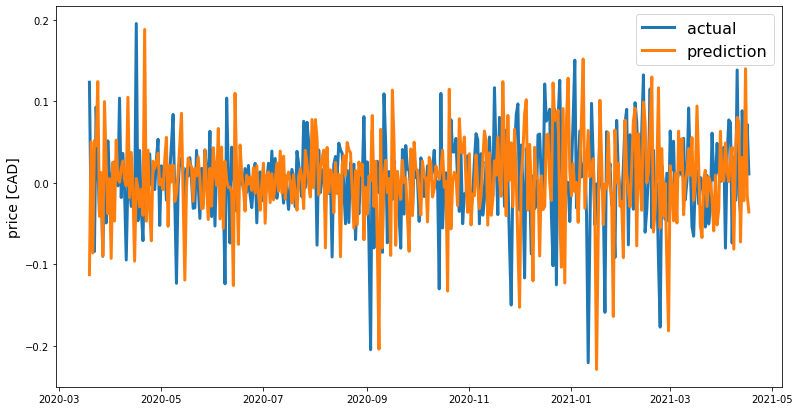

In [138]:
preds = test[target_column].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)